# Clean tweets
### Clean the tweets and pickle them for future use
1. In V1 of the project, removed all #tags too. After the prediction on the test set, it may be worth trying with #tags (just remove #)

## Mount files from Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 ## Import required libaries

In [1]:
!pip install emoji

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
%matplotlib inline
sns.set()
import emoji

## Load train and test data

In [3]:
#read files from the folder
path = '/content/drive/MyDrive/Guvi Files/Final Project2-V2/'
train_tweets = pd.read_csv(path+'data/train.csv', sep=',')
test_tweets = pd.read_csv(path+'data/test.csv',sep=',')


## EDA

In [4]:
train_tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
test_tweets.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
print (train_tweets.shape, test_tweets.shape)

(31962, 3) (17197, 2)


In [7]:
# ID columns in both train and test is of no use, we can drop them
train_tweets.drop('id', axis=1, inplace=True)
test_tweets.drop('id', axis=1, inplace=True)

In [8]:
# check for duplicates
train_tweets['tweet'].duplicated().sum()

2432

In [9]:
# drop duplicates from train tweets
train_tweets.drop_duplicates(subset=['tweet'], inplace = True)

In [10]:
train_tweets['tweet'].duplicated().sum()

0

## Check label/target distribution in the train dataset

In [11]:
train_tweets['label'].unique()

array([0, 1])

In [12]:
train_tweets['label'].value_counts()

,count
label,
0,27517
1,2013


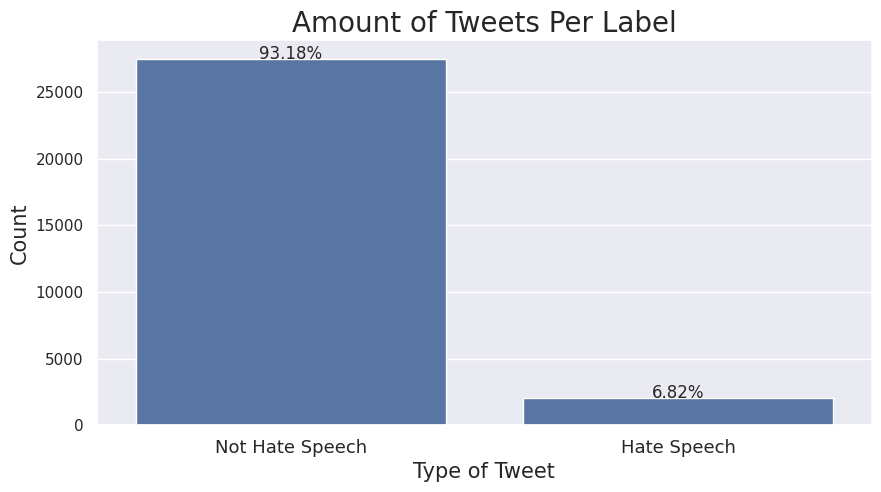

In [13]:
#matplot count plot
plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=train_tweets)
ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate Speech'],fontsize = 13)

total = float(len(train_tweets)) # one person per row
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center")
#save the chart
#plt.savefig(path + 'visualisations/label_imbalance.png',bbox_inches = 'tight', pad_inches = .5)

### Only 7% of the data is hate speech. We may have to over-sample hate speech or under-sample OK speech before building a model

## Clean text
- Clean tweets in train and test, add to a new col in the same DF. Pickle and store for future use

In [14]:
#Clean function
def clean_text1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make text lowercase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # remove all punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # getting rid of `httptco`
    text = re.sub('(httptco)', '', text)
    # remove non ASCII characters
    text = ''.join([word for word in text if word in string.printable])

    return text


def clean_text2(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # convert emojis to text
    text = emoji.demojize(text)
    # remove non ASCII characters
    text = ''.join([word for word in text if word in string.printable])
    return text

In [15]:
#appy clean text on train and test tweets
train_tweets['clean_tweet'] = train_tweets['tweet'].apply(lambda x: clean_text2(x))
test_tweets['clean_tweet'] = test_tweets['tweet'].apply(lambda x: clean_text2(x))

In [16]:
train_tweets.head()

,label,tweet,clean_tweet
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cant use cause they...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in u...
4,0,factsguide: society now #motivation,factsguide society now motivation


In [17]:
# check whether non ASCII chars are removed
print(train_tweets['tweet'][3],'\n',train_tweets['clean_tweet'][3])

#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦   
 model   i love u take with u all the time in ur   


## Tokenize and remove stop words

In [18]:
#remove stop words in train_clean_tweets
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')
def tokenize_and_remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
train_tweets['tokens'] = list(map(tokenize_and_remove_stopwords,train_tweets['clean_tweet']))
train_tweets.head()

,label,tweet,clean_tweet,tokens
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cant use cause they...,"[thanks, lyft, credit, cant, use, cause, dont,..."
2,0,bihday your majesty,bihday your majesty,"[bihday, majesty]"
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in u...,"[model, love, u, take, u, time, ur]"
4,0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, motivation]"


## Lemmatization

In [21]:
#lemmatize processed_data and convert from list of words to sentence again
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for lst in train_tweets['tokens']:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in lst])
    lemmatized_output.append(lemmed)

train_tweets['lem_tweet'] = lemmatized_output
train_tweets.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,label,tweet,clean_tweet,tokens,lem_tweet
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...,"[father, dysfunctional, selfish, drags, kids, ...",father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cant use cause they...,"[thanks, lyft, credit, cant, use, cause, dont,...",thanks lyft credit cant use cause dont offer w...
2,0,bihday your majesty,bihday your majesty,"[bihday, majesty]",bihday majesty
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in u...,"[model, love, u, take, u, time, ur]",model love u take u time ur
4,0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, motivation]",factsguide society motivation


## Wordcloud Visualisation

In [26]:
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
df_non_hate = train_tweets[train_tweets['label']==0]
df_hate = train_tweets[train_tweets['label']==1]
tweet_ok = " ".join(review for review in df_non_hate['clean_tweet'])
tweet_hate = " ".join(review for review in df_hate['clean_tweet'])

Text(0.5, 1.0, 'Hate Tweets')

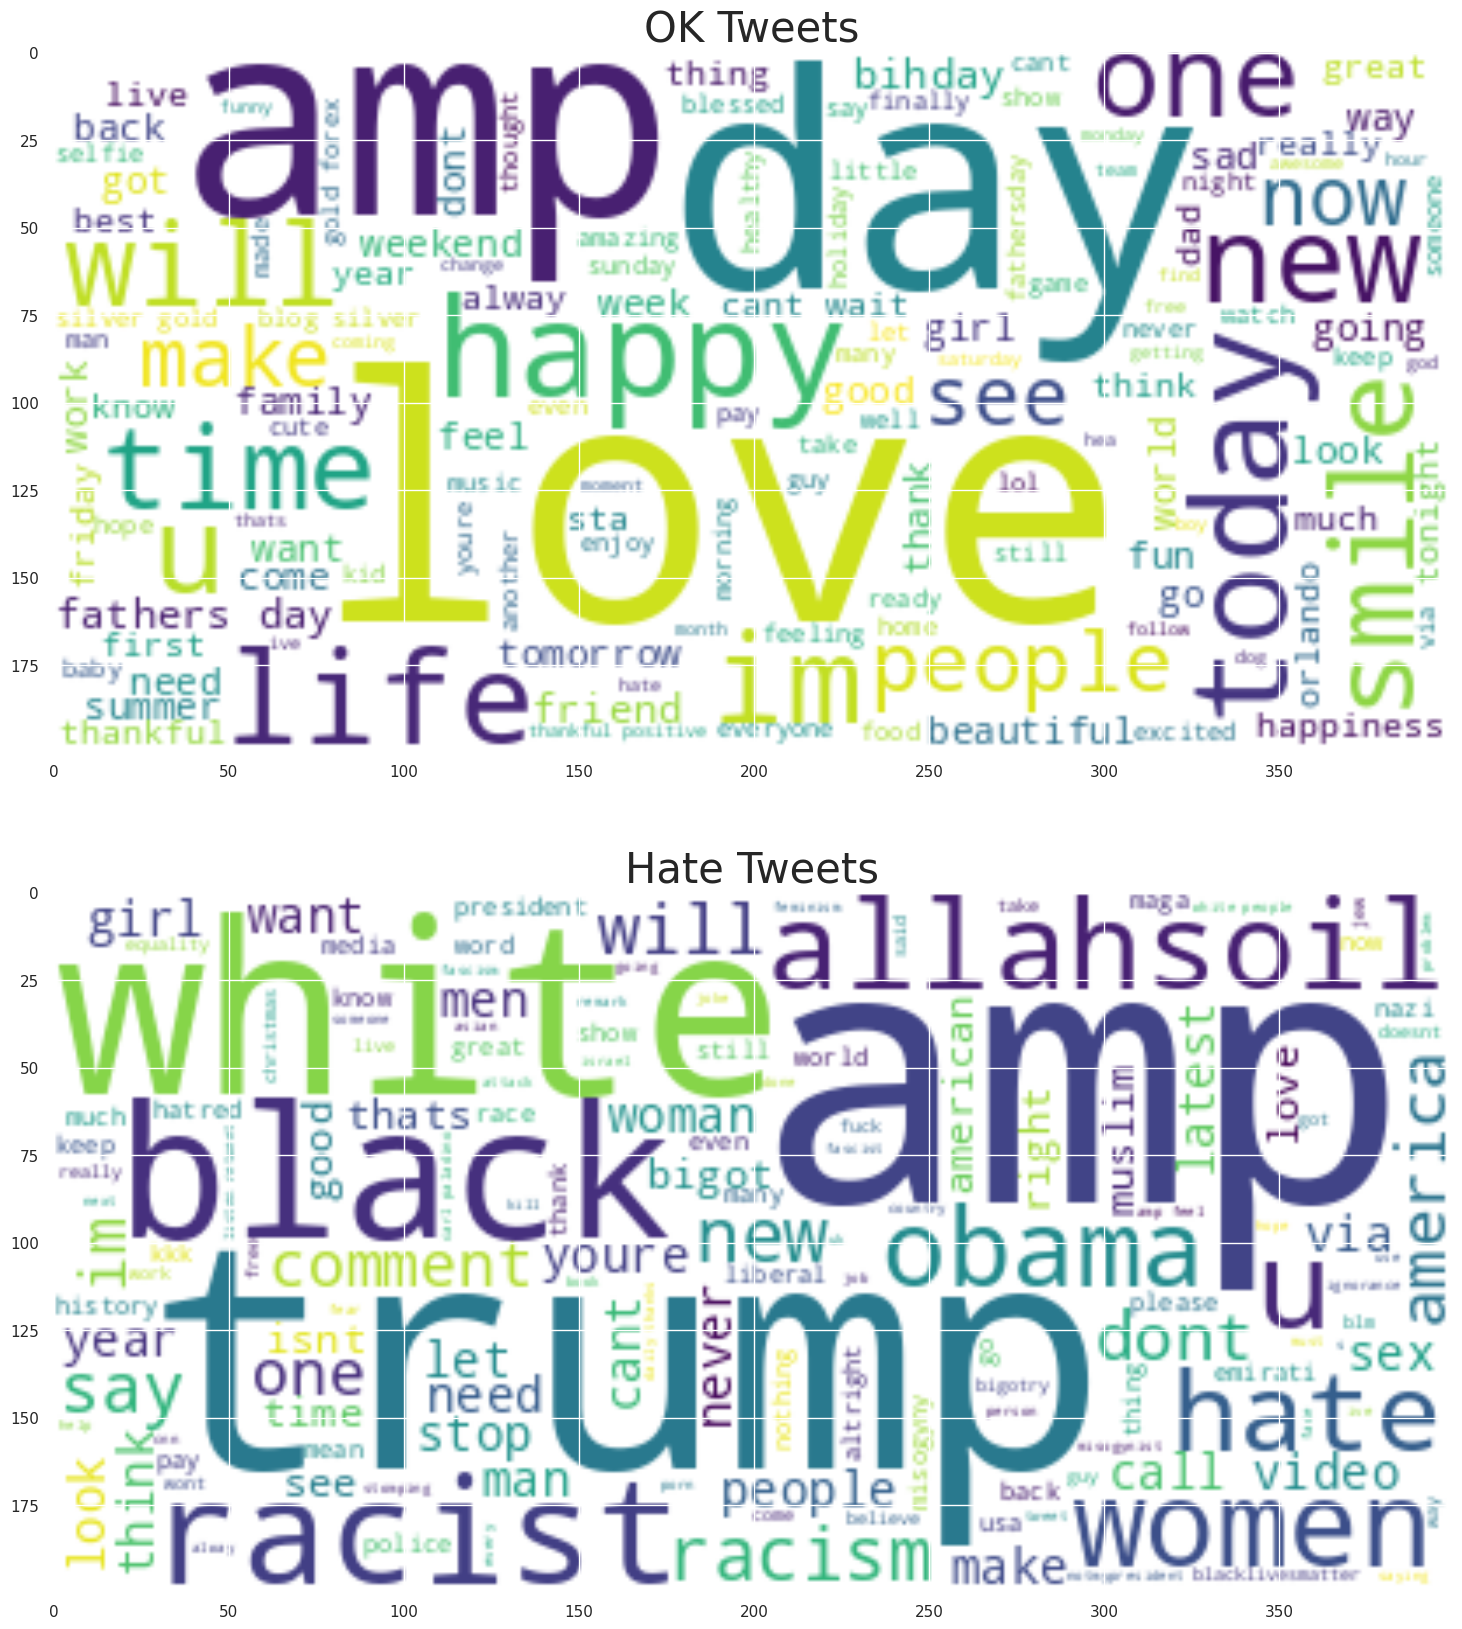

In [27]:
fig,ax = plt.subplots(2,1,figsize=(20,20))
# Generate a word cloud image
wc_ok = WordCloud(stopwords=STOPWORDS, background_color="white").generate(tweet_ok)
wc_hate = WordCloud(stopwords=STOPWORDS, background_color="white").generate(tweet_hate)
# Display the generated image:
ax[0].imshow(wc_ok, interpolation='bilinear')
ax[0].set_title('OK Tweets',fontsize = 30)
ax[1].imshow(wc_hate, interpolation='bilinear')
ax[1].set_title('Hate Tweets',fontsize = 30)


## write the pre processed data for later use

In [28]:
#pickle the df and store in drive for future reference
train_tweets.to_pickle(path+'data/train_tweets_clean.pkl')
test_tweets.to_pickle(path+'data/test_tweets_clean.pkl')